In [1]:
library(muhaz)
library(tidyverse)
library(lubridate)
library(survival)
library(dplyr)
library(knitr)
library(ggplot2)

Warning message:
"package 'muhaz' was built under R version 4.4.3"
Warning message:
"package 'tidyverse' was built under R version 4.4.3"
Warning message:
"package 'ggplot2' was built under R version 4.4.3"
Warning message:
"package 'readr' was built under R version 4.4.3"
Warning message:
"package 'forcats' was built under R version 4.4.3"
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   4.0.0     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors


---
# Data Cleaning

In [2]:
# https://data.sciencespo.fr/dataset.xhtml?persistentId=doi:10.21410/7E4/RDAG3O
bhht <- read.csv("../cross-verified-database.csv.gz")
# bhht <- read.csv("bhht_small.csv.gz")

bhht %>% colnames %>% sort

[1] "all_geography_groups"     "approx_birth"            
 [3] "approx_death"             "area1_of_rattachment"    
 [5] "area2_of_rattachment"     "bigperiod_birth"         
 [7] "bigperiod_birth_graph_b"  "bigperiod_death"         
 [9] "bigperiod_death_graph_b"  "birth"                   
[11] "birth_estimation"         "birth_max"               
[13] "birth_min"                "bpla1"                   
[15] "bplo1"                    "citizenship_1_b"         
[17] "citizenship_2_b"          "curid"                   
[19] "death"                    "death_estimation"        
[21] "death_max"                "death_min"               
[23] "dpla1"                    "dplo1"                   
[25] "freq_main_occ"            "freq_second_occ"         
[27] "gender"                   "group_wikipedia_editions"
[29] "level1_main_occ"          "level2_main_occ"         
[31] "level2_second_occ"        "level3_all_occ"          
[33] "level3_main_occ"          "list_areas_of_rattach"   
[35] "list_wikipedia_editions"  "name"                    
[37] "non_missing_score"        "number_wiki_editions"    
[39] "pantheon_1"               "ranking_visib_5criteria" 
[41] "string_citizenship_raw_d" "sum_visib_ln_5criteria"  
[43] "total_count_words_b"      "total_noccur_links_b"    
[45] "un_region"                "un_subregion"            
[47] "updated_death_date"       "wiki_readers_2015_2018"  
[49] "wikidata_code"

## Filter to past 100 years

In [3]:
current_year <- 2025
cutoff_year  <- 1925

bhht_clean <- bhht %>%
mutate(
# Convert to integers
birth = as.integer(birth),
death = as.integer(death),
death_min = as.integer(death_min),
death_max = as.integer(death_max),
updated_death_year = suppressWarnings(year(ymd(updated_death_date))),

# Choose best death year
death_best = coalesce(updated_death_year, death, death_min, death_max),

# Impute censoring for plausible living people
death_final = case_when(
  !is.na(death_best) ~ death_best,
  birth >= current_year - 110 ~ current_year,
  TRUE ~ NA_integer_
),

status = if_else(!is.na(death_best), 1L, 0L),

survival_time_age = death_final - birth,
survival_time_year = death_final - cutoff_year

) %>%
filter(
!is.na(death_final),
!is.na(birth),
survival_time_age > 0,
# number_wiki_editions > 1,  # reliable?
death_final >= cutoff_year # alive in last 100 years
)

bhht_clean %>% dim

[1] 1733825      55

In [4]:
total_records <- nrow(bhht)
subset_records <- nrow(bhht_clean)

cat("Total records:", total_records, "\n")
cat("Subset records after cleaning:", subset_records, "\n")
cat("Proportion retained:", round(subset_records / total_records, 4) * 100, "%\n")

Total records: 2291817 
Subset records after cleaning: 1733825 
Proportion retained: 75.65 %


---
# EDA

In [64]:
# Lifespan summaries
summary(bhht_clean$survival_time_age)
summary(bhht_clean$survival_time_year)

# Proportion censored
prop.table(table(bhht_clean$status))

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   1.00   49.00   66.00   63.83   79.00  169.00 

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   0.00   74.00  100.00   83.14  100.00  100.00 


        0         1 
0.6184032 0.3815968 

In [65]:
bhht_clean %>%
    group_by(gender) %>%
    summarise(count = n()) %>%
    arrange(desc(count)) %>%
    kable(col.names = c("Gender", "Number of People"), caption = "Number of People per Gender")



Table: Number of People per Gender

|Gender | Number of People|
|:------|----------------:|
|Male   |          1411362|
|Female |           321155|
|       |              796|
|Other  |              512|

In [62]:
bhht_clean %>%
    group_by(un_region) %>%
    summarise(count = n()) %>%
    arrange(desc(count)) %>%
    kable(col.names = c("UN Region", "Number of People"), caption = "Number of People per UN Region")



Table: Number of People per UN Region

|UN Region | Number of People|
|:---------|----------------:|
|Europe    |           909025|
|America   |           511335|
|Asia      |           170416|
|Oceania   |            67990|
|Africa    |            55393|
|Missing   |            19666|

In [63]:
bhht_clean %>%
    group_by(un_subregion) %>%
    summarise(count = n()) %>%
    arrange(desc(count)) %>%
    kable(col.names = c("UN Subregion", "Number of People"), caption = "Number of People per UN Subregion")



Table: Number of People per UN Subregion

|UN Subregion                        | Number of People|
|:-----------------------------------|----------------:|
|Western Europe                      |           544481|
|Northern America                    |           379788|
|Southern Europe                     |           159802|
|Northern Europe                     |           112254|
|South America                       |            95003|
|Eastern Europe                      |            92488|
|Oceania Western World               |            66374|
|Eastern Asia                        |            59987|
|South Asia incl. Indian Peninsula   |            46553|
|Western Asia (Middle East Caucasus) |            39174|
|Central America                     |            24327|
|SouthEast Asia                      |            20946|
|Missing                             |            19666|
|West Africa                         |            15935|
|North Africa                        |      

## Distribution by Gender

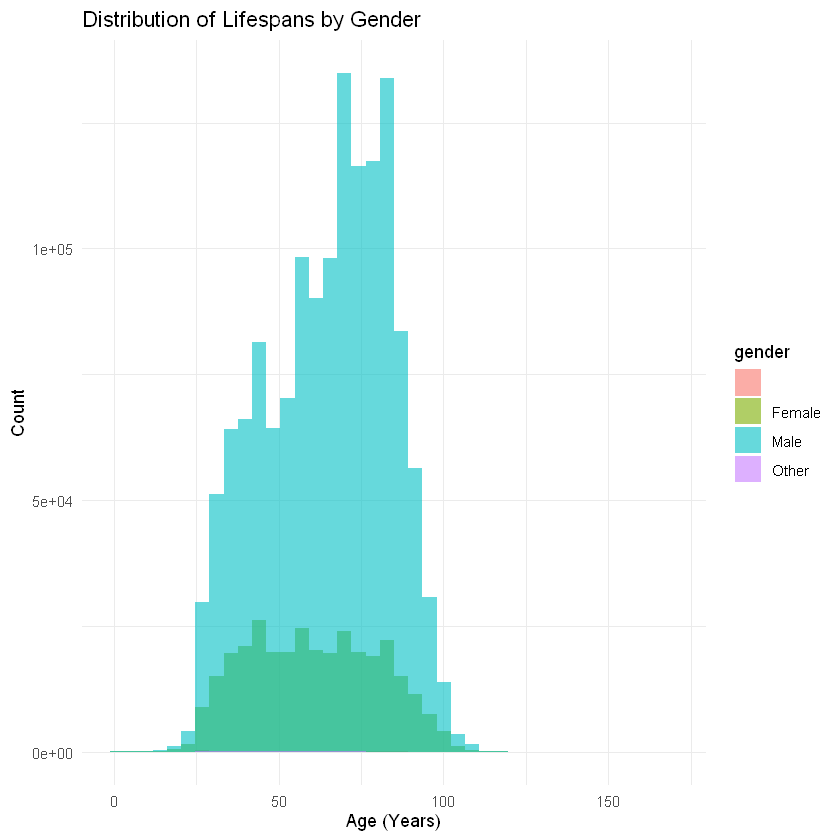

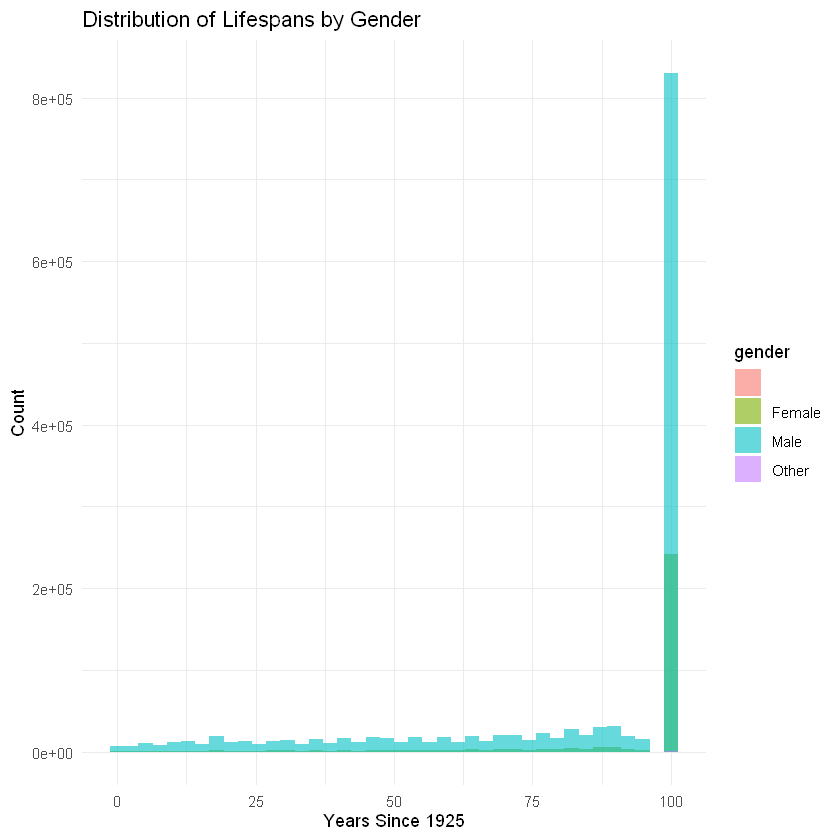

In [6]:
bhht_clean %>%
  ggplot(aes(x = survival_time_age, fill = gender)) +
  geom_histogram(bins = 40, position = "identity", alpha = 0.6) +
  labs(title = "Distribution of Lifespans by Gender", x = "Age (Years)", y = "Count") +
  theme_minimal()

bhht_clean %>%
  ggplot(aes(x = survival_time_year, fill = gender)) +
  geom_histogram(bins = 40, position = "identity", alpha = 0.6) +
  labs(title = "Distribution of Lifespans by Gender", x = "Years Since 1925", y = "Count") +
  theme_minimal()

## Distribution by UN Region

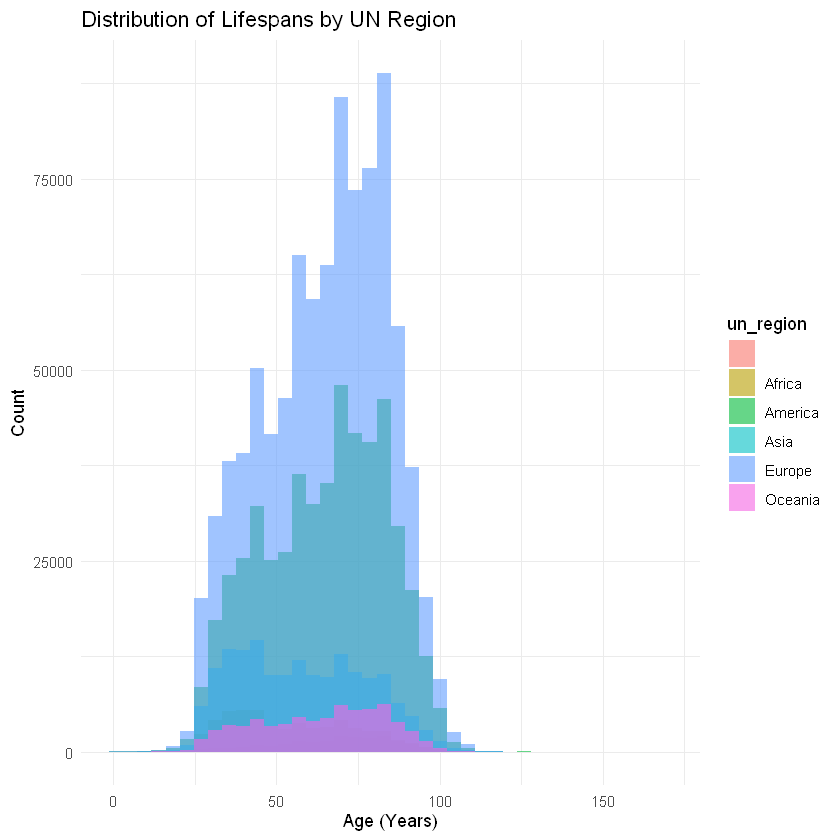

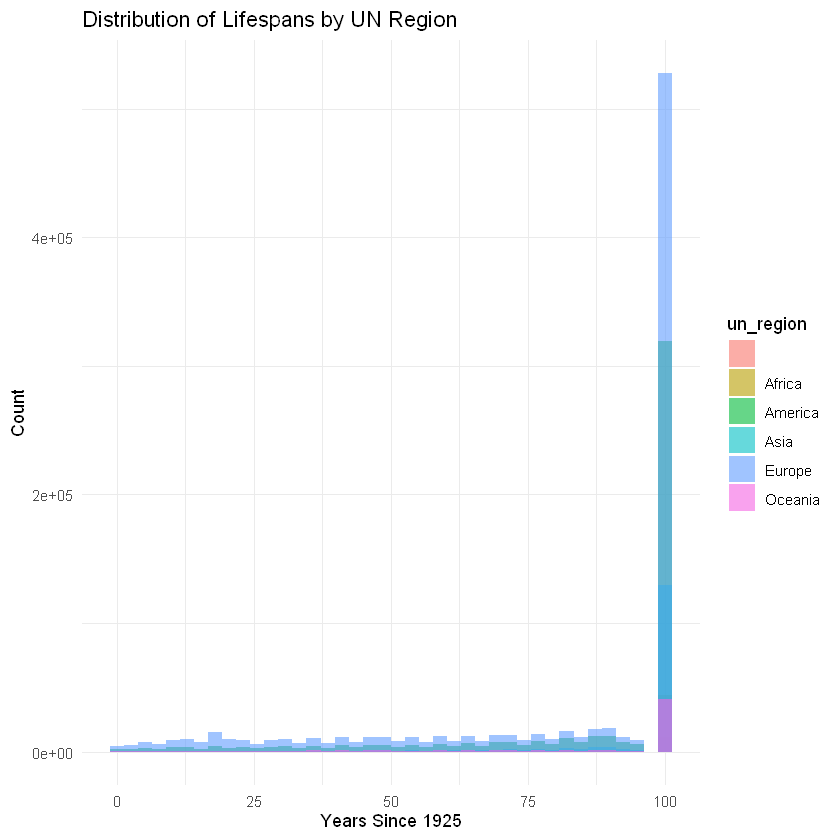

In [7]:
bhht_clean %>%
  ggplot(aes(x = survival_time_age, fill = un_region)) +
  geom_histogram(bins = 40, position = "identity", alpha = 0.6) +
  labs(title = "Distribution of Lifespans by UN Region", x = "Age (Years)", y = "Count") +
  theme_minimal()

bhht_clean %>%
  ggplot(aes(x = survival_time_year, fill = un_region)) +
  geom_histogram(bins = 40, position = "identity", alpha = 0.6) +
  labs(title = "Distribution of Lifespans by UN Region", x = "Years Since 1925", y = "Count") +
  theme_minimal()

#### By UN Subregion

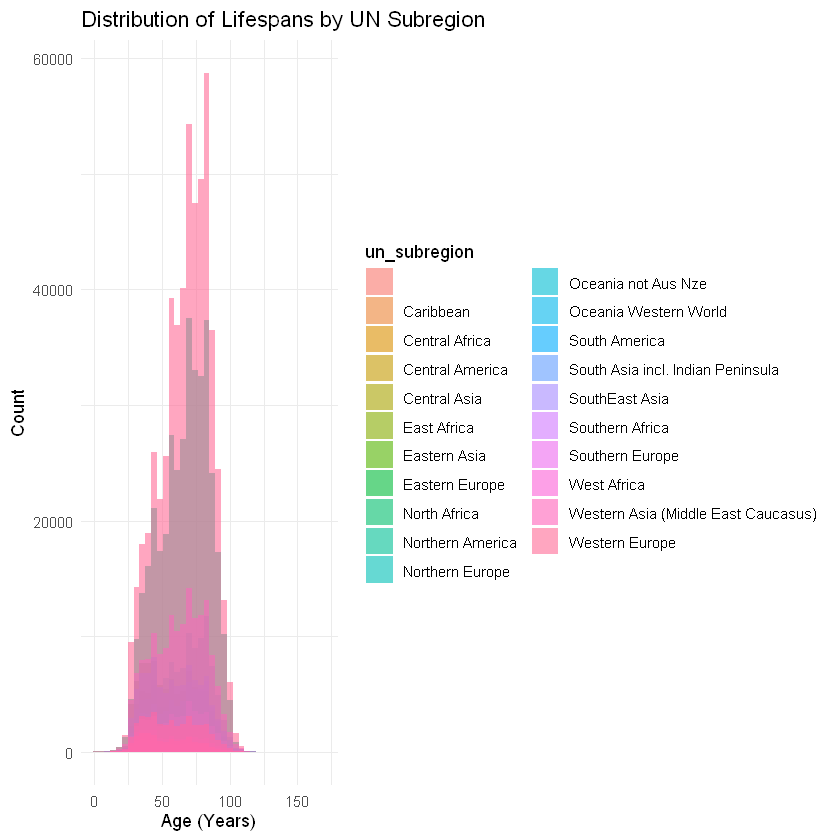

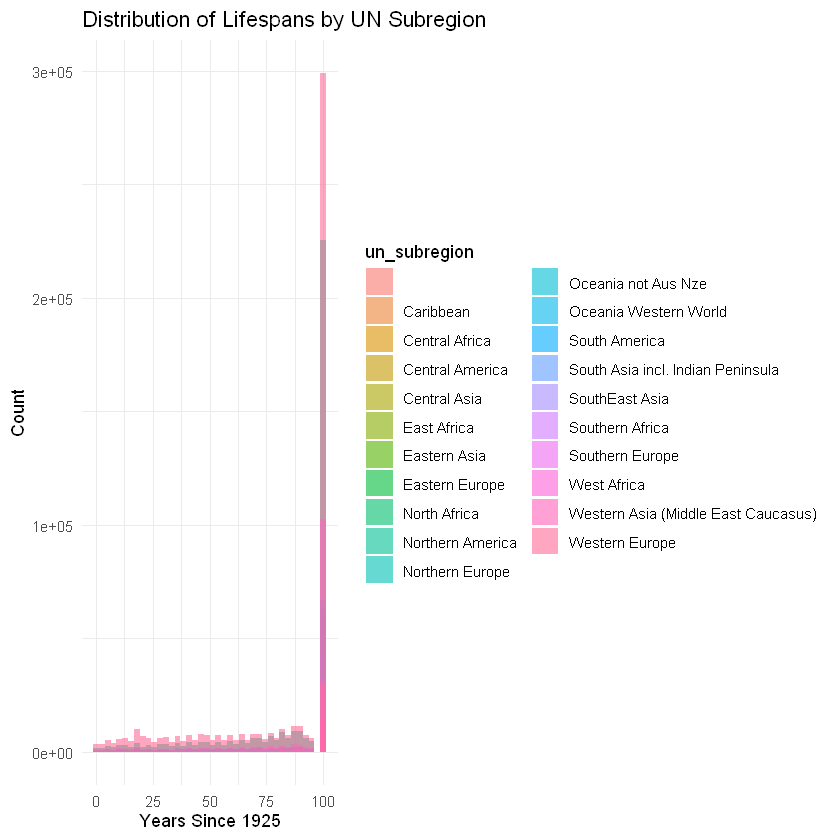

In [59]:
bhht_clean %>%
  ggplot(aes(x = survival_time_age, fill = un_subregion)) +
  geom_histogram(bins = 40, position = "identity", alpha = 0.6) +
  labs(title = "Distribution of Lifespans by UN Subregion", x = "Age (Years)", y = "Count") +
  theme_minimal()

bhht_clean %>%
  ggplot(aes(x = survival_time_year, fill = un_subregion)) +
  geom_histogram(bins = 40, position = "identity", alpha = 0.6) +
  labs(title = "Distribution of Lifespans by UN Subregion", x = "Years Since 1925", y = "Count") +
  theme_minimal()

## Distribution by L1 Occupation

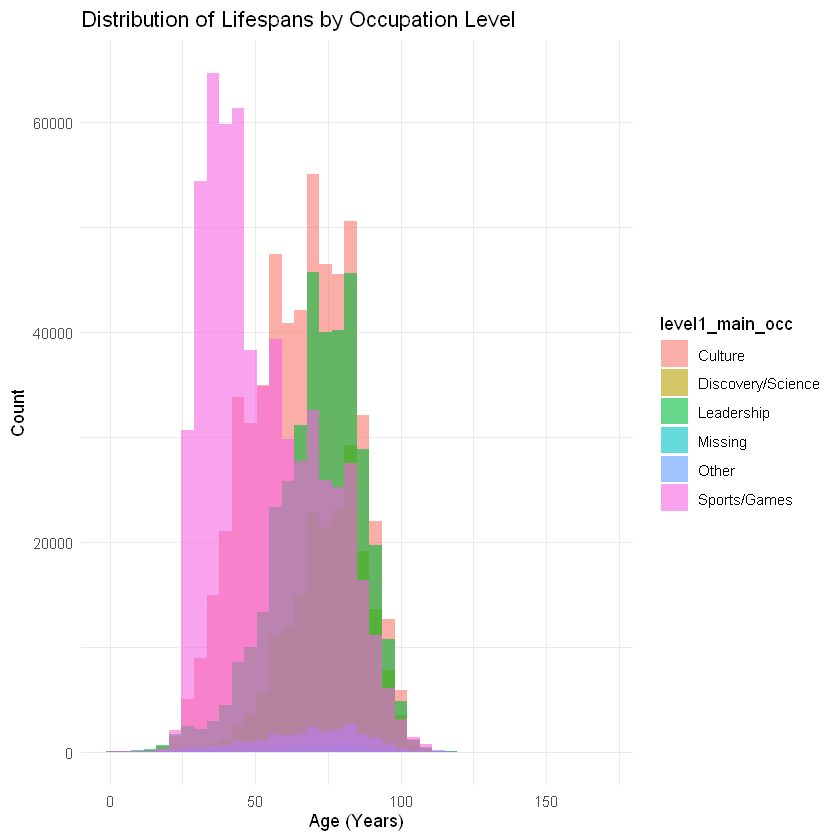

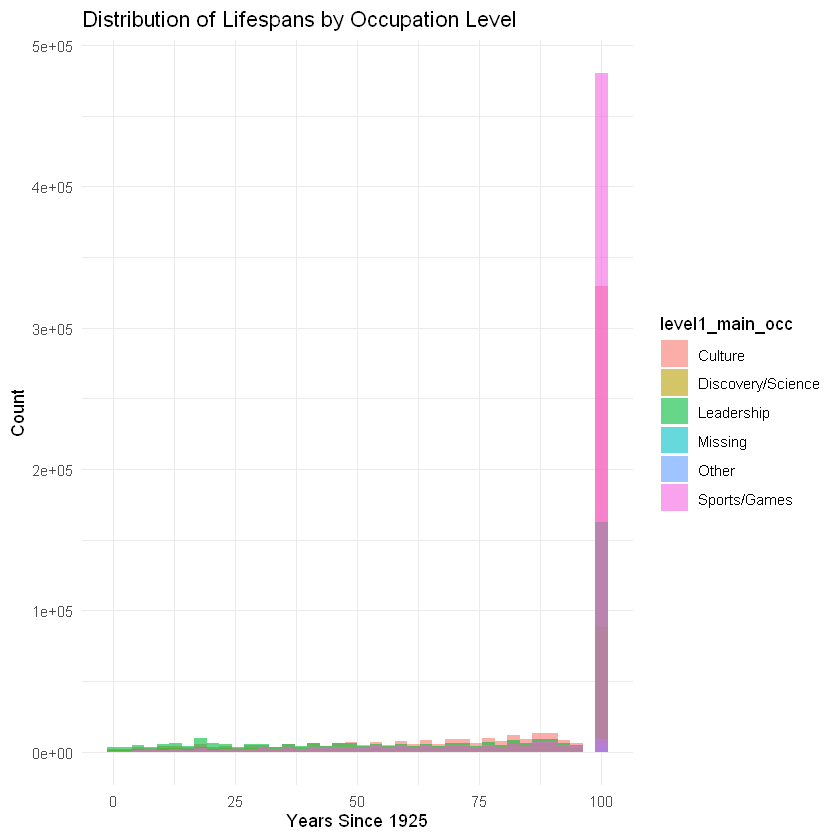

In [8]:
bhht_clean %>%
  ggplot(aes(x = survival_time_age, fill = level1_main_occ)) +
  geom_histogram(bins = 40, position = "identity", alpha = 0.6) +
  labs(title = "Distribution of Lifespans by Occupation Level", x = "Age (Years)", y = "Count") +
  theme_minimal()

bhht_clean %>%
  ggplot(aes(x = survival_time_year, fill = level1_main_occ)) +
  geom_histogram(bins = 40, position = "identity", alpha = 0.6) +
  labs(title = "Distribution of Lifespans by Occupation Level", x = "Years Since 1925", y = "Count") +
  theme_minimal()

---
# Age Based Survival Analysis

## Overall

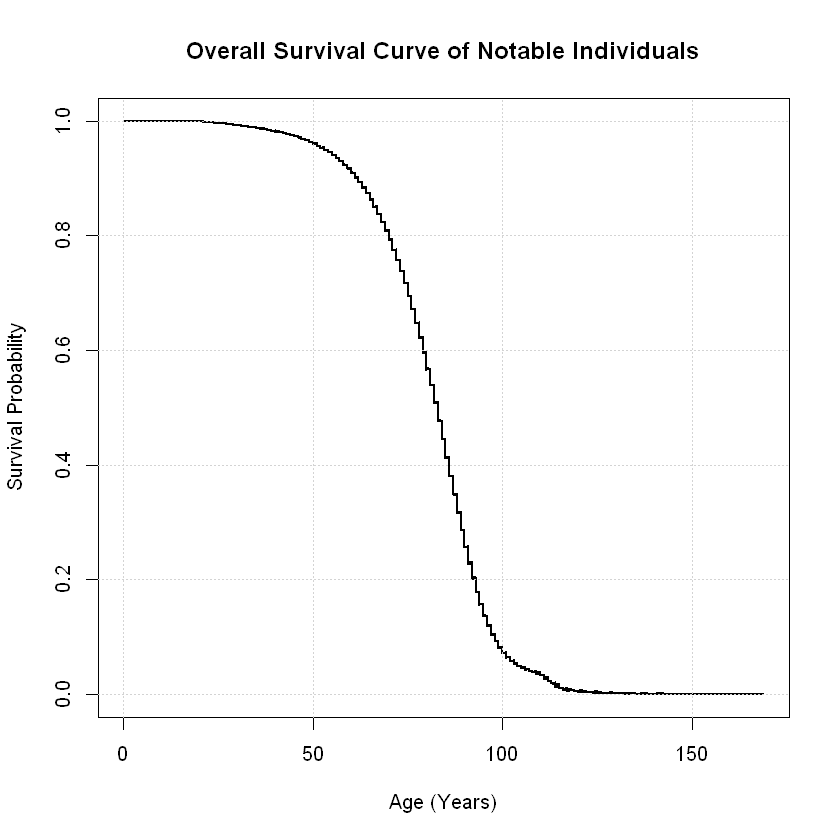

In [9]:
surv_obj <- Surv(time = bhht_clean$survival_time_age, event = bhht_clean$status)

km_fit <- survfit(surv_obj ~ 1, data = bhht_clean)

par(bg = 'white')
plot(km_fit,
     xlab = "Age (Years)",
     ylab = "Survival Probability",
     main = "Overall Survival Curve of Notable Individuals",
     col = "black",
     lwd = 2)
grid()

## By Gender

Call:
survdiff(formula = Surv(survival_time_age, status) ~ gender, 
    data = bhht_clean_gdr)

                    N Observed Expected (O-E)^2/E (O-E)^2/V
gender=Female  321155    79814   110490      8517     10746
gender=Male   1411362   581645   550969      1708     10746

 Chisq= 10746  on 1 degrees of freedom, p= <2e-16 

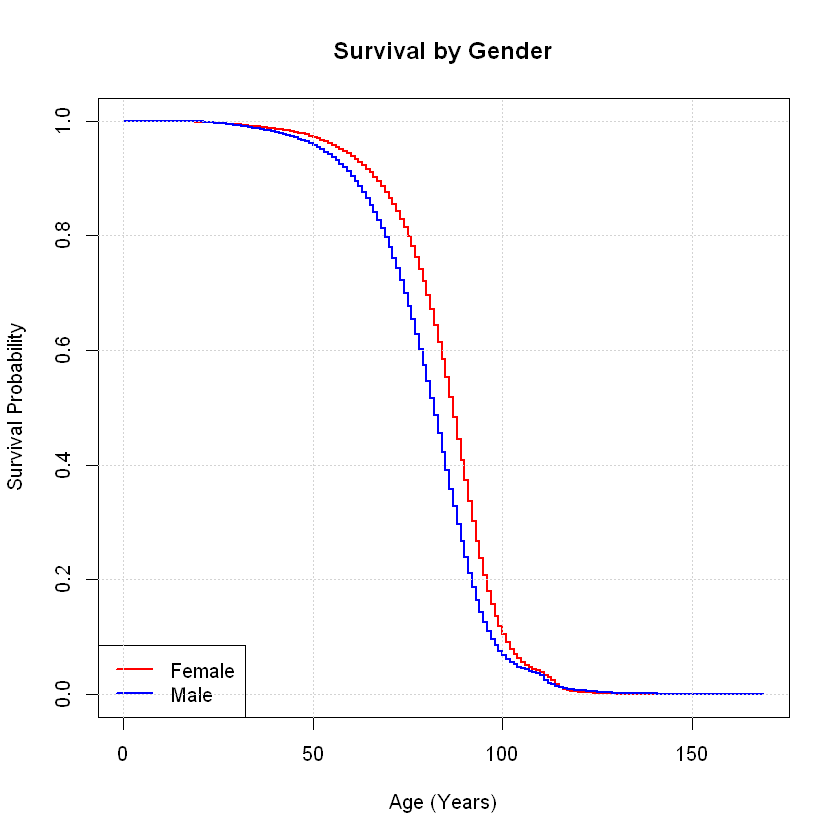

In [10]:
bhht_clean_gdr <- bhht_clean %>% filter(gender != "Other") %>% filter(!is.na(gender)) 
bhht_clean_gdr <- bhht_clean_gdr[!is.na(bhht_clean_gdr$gender) & 
                                 bhht_clean_gdr$gender != "Other" & 
                                 bhht_clean_gdr$gender != "", ]


surv_obj_age <- Surv(time = bhht_clean_gdr$survival_time_age, event = bhht_clean_gdr$status)
km_fit_gender <- survfit(surv_obj_age ~ gender, data = bhht_clean_gdr)

par(bg = 'white')
plot(km_fit_gender,
     xlab = "Age (Years)",
     ylab = "Survival Probability",
     main = "Survival by Gender",
     col = c("red", "blue"),
     lwd = 2)
legend("bottomleft", legend = levels(as.factor(bhht_clean_gdr$gender)),
       col = c("red", "blue"), lwd = 2)
grid()

# Log-rank test
survdiff(Surv(survival_time_age, status) ~ gender, data = bhht_clean_gdr)

Indicates that female individuals tend to live longer than their male counterparts among notable people in the past century.

## By UN Region

Call:
survdiff(formula = Surv(survival_time_age, status) ~ un_region, 
    data = bhht_clean)

                       N Observed Expected (O-E)^2/E (O-E)^2/V
un_region=Africa   55393    11265    12526     127.0     134.8
un_region=America 511335   192313   201899     455.1     685.3
un_region=Asia    170416    41203    49140    1281.9    1448.9
un_region=Europe  909025   381588   363971     852.7    1982.6
un_region=Missing  19666     8505     8920      19.3      20.5
un_region=Oceania  67990    26748    25165      99.6     108.1

 Chisq= 2967  on 5 degrees of freedom, p= <2e-16 

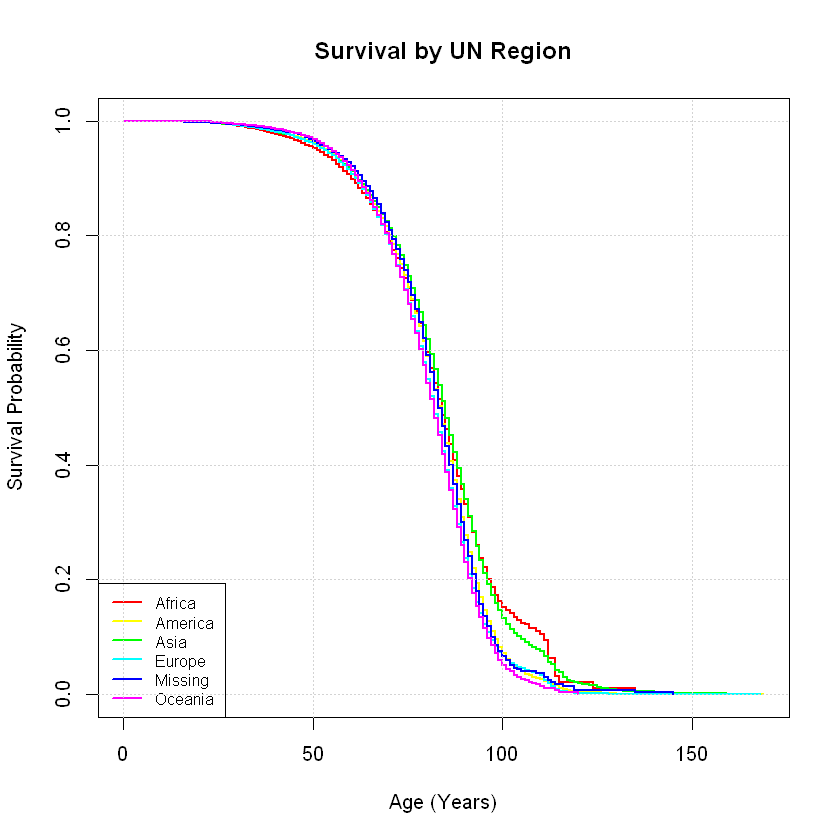

In [11]:
surv_obj_age <- Surv(time = bhht_clean$survival_time_age, event = bhht_clean$status)

# Relabel missing regions
bhht_clean$un_region[bhht_clean$un_region == ""] <- "Missing"

km_fit_region <- survfit(surv_obj_age ~ un_region, data = bhht_clean)

region_colors <- rainbow(length(unique(bhht_clean$un_region)))

par(bg='white')
plot(km_fit_region,
     xlab = "Age (Years)",
     ylab = "Survival Probability",
     main = "Survival by UN Region",
     col = region_colors,
     lwd = 2)
legend("bottomleft", legend = levels(as.factor(bhht_clean$un_region)),
       col = region_colors, lwd = 2, cex = 0.8)
grid()

# Log-rank test
survdiff(Surv(survival_time_age, status) ~ un_region, data = bhht_clean)

## By UN Subregion

Call:
survdiff(formula = Surv(survival_time_age, status) ~ un_subregion, 
    data = bhht_clean)

                                                      N Observed Expected
un_subregion=Caribbean                            12217     3064     3477
un_subregion=Central Africa                        4958      808      863
un_subregion=Central America                      24327     6491     7303
un_subregion=Central Asia                          3756      334      417
un_subregion=East Africa                          10499     1827     2103
un_subregion=Eastern Asia                         59987    11561    15878
un_subregion=Eastern Europe                       92488    30077    24271
un_subregion=Missing                              19666     8505     8920
un_subregion=North Africa                         12466     2783     3359
un_subregion=Northern America                    379788   154616   160729
un_subregion=Northern Europe                     112254    48389    46566
un_subregion=O

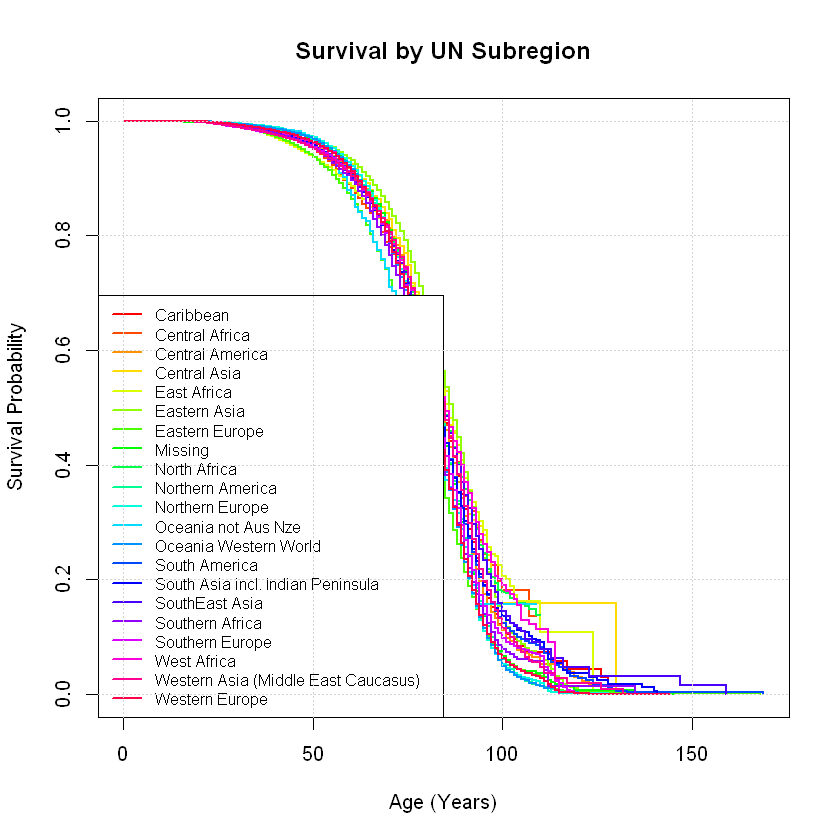

In [60]:
surv_obj_age <- Surv(time = bhht_clean$survival_time_age, event = bhht_clean$status)

# Relabel missing regions
bhht_clean$un_subregion[bhht_clean$un_subregion == ""] <- "Missing"

km_fit_region <- survfit(surv_obj_age ~ un_subregion, data = bhht_clean)

region_colors <- rainbow(length(unique(bhht_clean$un_subregion)))

par(bg='white')
plot(km_fit_region,
     xlab = "Age (Years)",
     ylab = "Survival Probability",
     main = "Survival by UN Subregion",
     col = region_colors,
     lwd = 2)
legend("bottomleft", legend = levels(as.factor(bhht_clean$un_subregion)),
       col = region_colors, lwd = 2, cex = 0.8)
grid()

# Log-rank test
survdiff(Surv(survival_time_age, status) ~ un_subregion, data = bhht_clean)

## By L1 Occupation

Call:
survdiff(formula = Surv(survival_time_age, status) ~ level1_main_occ, 
    data = bhht_clean)

                                       N Observed Expected (O-E)^2/E (O-E)^2/V
level1_main_occ=Culture           553686   223998   217109     218.6     340.3
level1_main_occ=Discovery/Science 193405   105323   116940    1154.0    1473.7
level1_main_occ=Leadership        363302   200695   185364    1268.0    1845.1
level1_main_occ=Missing             6758     4074     3510      90.5      95.8
level1_main_occ=Other              24312    15062    12513     519.4     562.4
level1_main_occ=Sports/Games      592362   112470   126187    1491.0    1938.1

 Chisq= 4977  on 5 degrees of freedom, p= <2e-16 

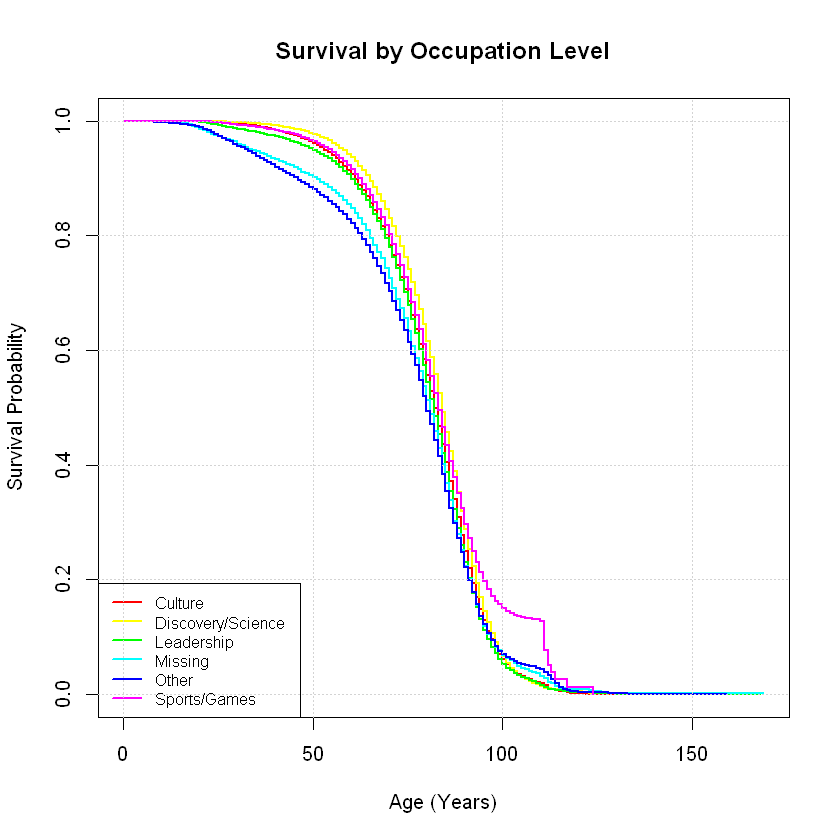

In [12]:
surv_obj_age <- Surv(time = bhht_clean$survival_time_age, event = bhht_clean$status)
km_fit_region <- survfit(surv_obj_age ~ level1_main_occ, data = bhht_clean)

region_colors <- rainbow(length(unique(bhht_clean$level1_main_occ)))

par(bg='white')
plot(km_fit_region,
     xlab = "Age (Years)",
     ylab = "Survival Probability",
     main = "Survival by Occupation Level",
     col = region_colors,
     lwd = 2)
legend("bottomleft", legend = levels(as.factor(bhht_clean$level1_main_occ)),
       col = region_colors, lwd = 2, cex = 0.8)
grid()

# Log-rank test
survdiff(Surv(survival_time_age, status) ~ level1_main_occ, data = bhht_clean)

---
## Cox Proportional Hazards Model

In [13]:
bhht_clean_filtered <- bhht_clean %>%
  mutate(
    gender = as.character(gender),
    un_region = as.character(un_region),
    level1_main_occ = as.character(level1_main_occ)
  ) %>%
  # Comment out filters if needed
  filter(
    !is.na(gender), gender != "Other", gender != "",
    !is.na(un_region), un_region != "Other", un_region != "Missing", un_region != "",
    !is.na(level1_main_occ), level1_main_occ != "Other", level1_main_occ != "Missing", level1_main_occ != ""
  ) %>%
  mutate(
    gender = factor(gender),
    un_region = factor(un_region),
    level1_main_occ = factor(level1_main_occ)
  ) %>%

  # Drop unused factor levels
  mutate(
    gender = droplevels(gender),
    un_region = droplevels(un_region),
    level1_main_occ = droplevels(level1_main_occ)
  )

levels(bhht_clean_filtered$gender)
levels(bhht_clean_filtered$un_region)
levels(bhht_clean_filtered$level1_main_occ)

[1] "Female" "Male"

[1] "Africa"  "America" "Asia"    "Europe"  "Oceania"

[1] "Culture"           "Discovery/Science" "Leadership"       
[4] "Sports/Games"

In [14]:
cox_age <- coxph(Surv(survival_time_age, status) ~ gender + un_region + level1_main_occ, data = bhht_clean_filtered)
summary(cox_age)
cox.zph(cox_age)

Call:
coxph(formula = Surv(survival_time_age, status) ~ gender + un_region + 
    level1_main_occ, data = bhht_clean_filtered)

  n= 1683489, number of events= 634873 

                                      coef exp(coef)  se(coef)       z Pr(>|z|)
genderMale                        0.422209  1.525327  0.003978 106.136  < 2e-16
un_regionAmerica                  0.080754  1.084104  0.009855   8.194 2.53e-16
un_regionAsia                    -0.080908  0.922279  0.010807  -7.486 7.08e-14
un_regionEurope                   0.176720  1.193297  0.009729  18.164  < 2e-16
un_regionOceania                  0.228335  1.256506  0.011435  19.967  < 2e-16
level1_main_occDiscovery/Science -0.192067  0.825251  0.003792 -50.652  < 2e-16
level1_main_occLeadership         0.002300  1.002303  0.003148   0.731    0.465
level1_main_occSports/Games      -0.225223  0.798338  0.003750 -60.057  < 2e-16
                                    
genderMale                       ***
un_regionAmerica                 ***


                chisq df      p
gender           2001  1 <2e-16
un_region         749  4 <2e-16
level1_main_occ  3158  3 <2e-16
GLOBAL           5746  8 <2e-16

---
# Calendar Year Based Survival Analysis

## Death Counts by Year

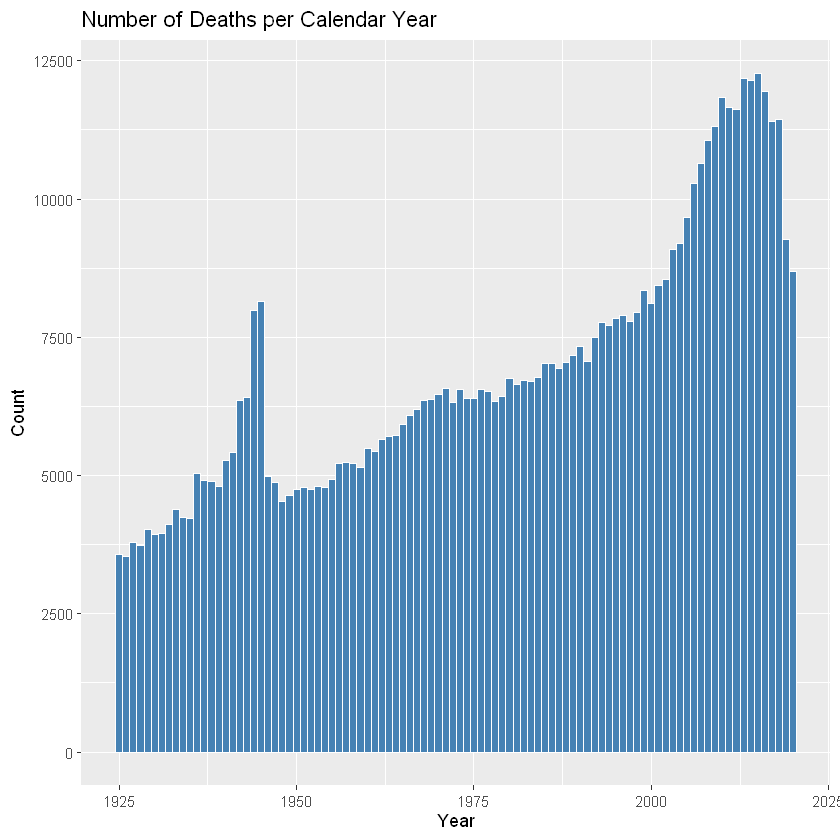

In [18]:
bhht_clean %>%
filter(status == 1) %>%
ggplot(aes(x = death_final)) +
geom_histogram(binwidth = 1, fill="steelblue", color="white") +
labs(title="Number of Deaths per Calendar Year", x="Year", y="Count")

In [27]:
death_counts <- bhht_clean %>%
    filter(status == 1) %>%
    group_by(death_final) %>%
    summarise(count = n()) %>%
    arrange(death_final)

kable(death_counts, col.names = c("Year", "Number of Deaths"), caption = "Number of Deaths per Year")



Table: Number of Deaths per Year

| Year| Number of Deaths|
|----:|----------------:|
| 1925|             3565|
| 1926|             3545|
| 1927|             3796|
| 1928|             3735|
| 1929|             4017|
| 1930|             3934|
| 1931|             3954|
| 1932|             4123|
| 1933|             4378|
| 1934|             4237|
| 1935|             4217|
| 1936|             5035|
| 1937|             4906|
| 1938|             4886|
| 1939|             4794|
| 1940|             5269|
| 1941|             5417|
| 1942|             6362|
| 1943|             6419|
| 1944|             7987|
| 1945|             8151|
| 1946|             4974|
| 1947|             4878|
| 1948|             4525|
| 1949|             4647|
| 1950|             4750|
| 1951|             4791|
| 1952|             4750|
| 1953|             4808|
| 1954|             4775|
| 1955|             4926|
| 1956|             5223|
| 1957|             5228|
| 1958|             5211|
| 1959|             5143|
| 

`geom_smooth()` using formula = 'y ~ x'


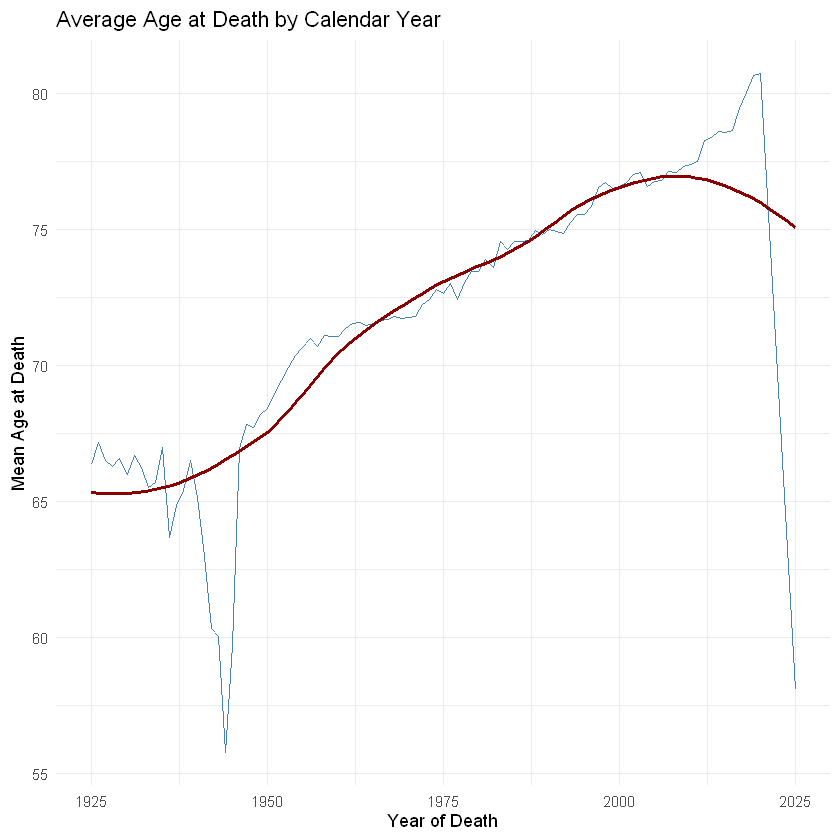

In [30]:
bhht_clean %>%
  group_by(death_final) %>%
  summarise(mean_age = mean(survival_time_age, na.rm = TRUE)) %>%
  ggplot(aes(x = death_final, y = mean_age)) +
  geom_line(color = "steelblue") +
  geom_smooth(method = "loess", color = "darkred", se = FALSE) +
  labs(
    title = "Average Age at Death by Calendar Year",
    x = "Year of Death",
    y = "Mean Age at Death"
  ) +
  theme_minimal()

- Average age of death skews sharply downward in 1940s. Likely due to war
- Average age of death rises over time. People may be healthier, higher quality of living, time of peace, etc.
- See a decrease in 2015 onward, could be related to COVID, the fact that this is likely an upper limit on maximum age for those born in the past 100 years.

In [73]:
library(ggplot2)
library(dplyr)
library(maps)
library(viridis)

# Filter and prepare data
death_map <- bhht_clean %>%
  # Valid coordinates and death years
  filter(!is.na(dpla1), !is.na(dplo1),
         dpla1 >= -90, dpla1 <= 90,
         dplo1 >= -180, dplo1 <= 180,
         !is.na(death_final)) %>%
  mutate(decade = floor(death_final / 10) * 10) %>%
  filter(decade >= cutoff_year, decade <= current_year)

# Load world map data
world <- map_data("world")

# Create output folders
if (!dir.exists("plots")) dir.create("plots")
if (!dir.exists("plots/total")) dir.create("plots/total")

unique_decades <- sort(unique(death_map$decade))

for (decade in unique_decades) {
  decade_data <- death_map %>% filter(decade == !!decade)
  
  p <- ggplot() +
    geom_polygon(
      data = world,
      aes(x = long, y = lat, group = group),
      color = "gray70", fill = "gray95", size = 0.2
    ) +
    stat_density_2d(
      data = decade_data,
      aes(x = dplo1, y = dpla1, fill = ..level.., alpha = ..level..),
      geom = "polygon", bins = 30
    ) +
    scale_fill_viridis_c(option = "plasma") +
    scale_alpha(range = c(0.2, 0.6), guide = "none") +
    coord_fixed(1.3) +
    theme_minimal() +
    labs(
      title = paste("Geographic Density of Death Locations -", decade),
      subtitle = "Notable individuals in BHHT dataset",
      x = "Longitude",
      y = "Latitude",
      fill = "Density"
    )
  
  ggsave(filename = paste0("plots/total/death_density_", decade, ".png"),
         plot = p, width = 10, height = 6, dpi = 300)
}

In [74]:
library(dplyr)
library(ggplot2)
library(maps)
library(viridis)

set.seed(42)

death_map <- bhht_clean %>%
  filter(
    !is.na(dpla1), !is.na(dplo1),
    dpla1 >= -90, dpla1 <= 90,
    dplo1 >= -180, dplo1 <= 180,
    !is.na(death_final),
    !is.na(un_region)
  ) %>%
  mutate(decade = floor(death_final / 10) * 10) %>%
  filter(decade >= cutoff_year, decade <= current_year)

world <- map_data("world")

if (!dir.exists("plots")) dir.create("plots")
if (!dir.exists("plots/regions")) dir.create("plots/regions")

unique_decades <- sort(unique(death_map$decade))
for (decade in unique_decades) {
  
  # Subset to current decade and calculate counts
  decade_data <- death_map %>%
    filter(decade == !!decade) %>%
    group_by(dpla1, dplo1, un_region) %>%
    summarise(count = n(), .groups = "drop") %>%
    group_by(un_region) %>%
    group_modify(~ {
      n_take <- min(10000, nrow(.x))
      dplyr::slice_sample(.x, n = n_take)
    }) %>%
    ungroup()
  
  p <- ggplot() +
    geom_polygon(
      data = world,
      aes(x = long, y = lat, group = group),
      color = "gray70", fill = "gray95", size = 0.2
    ) +
    geom_point(
      data = decade_data,
      aes(x = dplo1, y = dpla1, color = un_region, size = count),
      alpha = 0.5
    ) +
    scale_color_brewer(palette = "Set1") +
    scale_size_continuous(range = c(1, 5), guide = "legend") +
    coord_fixed(1.3) +
    theme_minimal() +
    labs(
      title = paste("Death Locations by UN Region -", decade),
      subtitle = "Point size represents the number of deaths",
      x = "Longitude",
      y = "Latitude",
      color = "UN Region",
      size = "Number of Deaths"
    )
  
  ggsave(
    filename = paste0("plots/regions/death_points_", decade, ".png"),
    plot = p,
    width = 10,
    height = 6,
    dpi = 300
  )
  
  message("Saved plot for decade ", decade)
}


Saved plot for decade 1930

Saved plot for decade 1940

Saved plot for decade 1950

Saved plot for decade 1960

Saved plot for decade 1970

Saved plot for decade 1980

Saved plot for decade 1990

Saved plot for decade 2000

Saved plot for decade 2010

Saved plot for decade 2020



- Points are colored by the birthplace of the individual, and may be somewhat interesting trying to see if people migrate from their birthplace. 
- Honestly it's been really difficult trying to perform surv analysis on the calendar year lol